In [1]:
#!pip  install subword-nmt
#!pip install nltk
#!pip install torchtext==0.11.0
#!pip install transformers

In [2]:
import pandas as pd
from transformers import AutoTokenizer

In [3]:
phoenix_dataset_dev = '/Users/alua/Desktop/PHOENIX-2014-T.dev.corpus.csv'
phoenix_dataset_test = '/Users/alua/Desktop/PHOENIX-2014-T.test.corpus.csv'
phoenix_dataset_train = '/Users/alua/Desktop/PHOENIX-2014-T.train.corpus.csv'
# Load the Phoenix dataset
phoenix_dev = pd.read_csv(phoenix_dataset_dev, sep="|")
phoenix_test = pd.read_csv(phoenix_dataset_test, sep="|")
phoenix_train = pd.read_csv(phoenix_dataset_train, sep="|")


In [4]:
phoenix_all = pd.concat([phoenix_dev, phoenix_test, phoenix_train])

In [5]:
phoenix_all.shape

(8257, 7)

In [6]:
phoenix_all.head(5)

,name,video,start,end,speaker,orth,translation
0,11August_2010_Wednesday_tagesschau-2,11August_2010_Wednesday_tagesschau-2/1/*.png,-1,-1,Signer08,DRUCK TIEF KOMMEN,tiefer luftdruck bestimmt in den nächsten tage...
1,11August_2010_Wednesday_tagesschau-3,11August_2010_Wednesday_tagesschau-3/1/*.png,-1,-1,Signer08,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...,das bedeutet viele wolken und immer wieder zum...
2,11August_2010_Wednesday_tagesschau-8,11August_2010_Wednesday_tagesschau-8/1/*.png,-1,-1,Signer08,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...,meist weht nur ein schwacher wind aus untersch...
3,25October_2010_Monday_tagesschau-22,25October_2010_Monday_tagesschau-22/1/*.png,-1,-1,Signer01,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...,am mittwoch hier und da nieselregen in der nor...
4,05May_2011_Thursday_tagesschau-25,05May_2011_Thursday_tagesschau-25/1/*.png,-1,-1,Signer08,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...,und nun die wettervorhersage für morgen freita...


In [7]:
phoenix_need = phoenix_all[['translation', 'orth']]

In [8]:
phoenix_need.head(5)

,translation,orth
0,tiefer luftdruck bestimmt in den nächsten tage...,DRUCK TIEF KOMMEN
1,das bedeutet viele wolken und immer wieder zum...,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...
2,meist weht nur ein schwacher wind aus untersch...,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...
3,am mittwoch hier und da nieselregen in der nor...,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...
4,und nun die wettervorhersage für morgen freita...,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...


In [9]:
phoenix_need = phoenix_need.rename(columns={"translation": "src", "orth": "trg"})

In [10]:
phoenix_need.to_csv('phoenix_need.csv', sep="\t", index = False)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [12]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer

In [13]:
path = '/Users/alua/Desktop/work_study/DiplomaMSAI/workspace0/phoenix_need.csv'

In [14]:
import transformers

print(transformers.__version__)

4.25.1


In [15]:
model_checkpoint = "mariav/helsinki-opus-de-en-fine-tuned-wmt16"

In [16]:
from datasets import load_metric
metric = load_metric("sacrebleu")

/var/folders/fn/71jqbgcd6kg5ckn934wqkvzh0000gn/T/ipykernel_40854/3063495125.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [17]:
phoenix_need

,src,trg
0,tiefer luftdruck bestimmt in den nächsten tage...,DRUCK TIEF KOMMEN
1,das bedeutet viele wolken und immer wieder zum...,ES-BEDEUTET VIEL WOLKE UND KOENNEN REGEN GEWIT...
2,meist weht nur ein schwacher wind aus untersch...,WIND MAESSIG SCHWACH REGION WENN GEWITTER WIND...
3,am mittwoch hier und da nieselregen in der nor...,MITTWOCH REGEN KOENNEN NORDWEST WAHRSCHEINLICH...
4,und nun die wettervorhersage für morgen freita...,JETZT WETTER WIE-AUSSEHEN MORGEN FREITAG SECHS...
...,...,...
7091,am dienstag wird es sehr windig und es regnet ...,DIENSTAG WIND STARK REGEN KOMMEN
7092,am mittwoch legt der wind noch zu und es regne...,MITTWOCH WIND MEHR REGEN
7093,im süden zeigt sich aber auch die sonne,SUED REGION SONNE AUCH DABEI
7094,der donnerstag beginnt oft freundlich später z...,DONNERSTAG FREUNDLICH SONNE DANN SPAETER KOMME...


In [18]:
tokenizer_SRC = AutoTokenizer.from_pretrained(model_checkpoint)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [19]:
tokenizer_W = WordPunctTokenizer()
#tokenizer_W = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenizer_TRG(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [20]:
model = transformers.AutoModel.from_pretrained(model_checkpoint, from_tf=True)
# Extract the encoder
encoder_model = model.encoder
encoder_model.eval()

All TF 2.0 model weights were used when initializing MarianModel.

All the weights of MarianModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use MarianModel for predictions without further training.


MarianEncoder(
  (embed_tokens): Embedding(58101, 512, padding_idx=58100)
  (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
  (layers): ModuleList(
    (0): MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=True)
        (v_proj): Linear(in_features=512, out_features=512, bias=True)
        (q_proj): Linear(in_features=512, out_features=512, bias=True)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (activation_fn): SiLUActivation()
      (fc1): Linear(in_features=512, out_features=2048, bias=True)
      (fc2): Linear(in_features=2048, out_features=512, bias=True)
      (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (1): MarianEncoderLayer(
      (self_attn): MarianAttention(
        (k_proj): Linear(in_features=512, out_features=512, bias=Tr

In [21]:
trg_sentenceLst = phoenix_need.trg
import re
pattern = re.compile(r'\s+|-')

words = []
for sentence in trg_sentenceLst:
  words.append(re.split(pattern, sentence))

In [22]:
trg_words = [word.lower() for lst in words for word in lst]
len(trg_words)

65114

In [23]:
trg_unique_words = set(trg_words)
print('unique words in TRG: ',len(trg_unique_words))

unique words in TRG:  996


In [24]:
tokens = []
for sentence in trg_sentenceLst:
  tokens.append(tokenizer_TRG(sentence))
trg_tokens = [token for lst in tokens for token in lst]
len(trg_tokens)

67219

In [25]:
trg_unique_tokens = set(trg_tokens)
print('unique tokens in TRG: ',len(trg_unique_tokens))

unique tokens in TRG:  976


In [26]:
trg_unique_tokens

{'+',
 '-',
 'a',
 'aachen',
 'ab',
 'abend',
 'aber',
 'abfallen',
 'abkuehlen',
 'abschied',
 'abschnitt',
 'absinken',
 'abwechseln',
 'ach',
 'acht',
 'achte',
 'achthundert',
 'achtung',
 'achtzehn',
 'achtzig',
 'aehnlich',
 'aendern',
 'afrika',
 'aktiv',
 'aktuell',
 'alle',
 'allem',
 'allgaeu',
 'allgemein',
 'alpen',
 'alpenrand',
 'alpental',
 'als',
 'also',
 'alt',
 'am',
 'amerika',
 'an',
 'andere',
 'anders',
 'anfang',
 'angemessen',
 'angenehm',
 'angst',
 'anhalt',
 'anklicken',
 'ankommen',
 'ansammeln',
 'anschauen',
 'april',
 'arm',
 'atlantik',
 'auch',
 'auf',
 'aufbluehen',
 'aufeinandertreffen',
 'auffuellen',
 'aufheitern',
 'aufhoeren',
 'aufklaren',
 'aufkommen',
 'auflockerung',
 'aufloesen',
 'aufpassen',
 'auftauchen',
 'aufteilen',
 'aufziehen',
 'august',
 'aus',
 'auseinander',
 'aushalten',
 'ausnahme',
 'ausrichten',
 'aussehen',
 'aussergewoehnlich',
 'aussicht',
 'auswaehlen',
 'auto',
 'autobahn',
 'automatisch',
 'b',
 'baden',
 'bald',
 'baue

In [27]:
# for information, which words are not i listt
not_in_list2 = [word for word in trg_unique_words if word not in trg_unique_tokens]
print("Words in list1 that are not in list2:", not_in_list2)

Words in list1 that are not in list2: ['c+m', 'm+l', 'm+m', 'j+l+i', 'i+s', 'f+e+r+z', 'p+o+p', 'w+e', 'sch+h', 'e+r+z', 'y+i+y', 'o+p+h+e+l+i+a', 'g+u+nn+e+r', 'z+y+p', 'sch+e+w+e+b+y', 'v+o+i+g+t', 's+y+l+t', 'z+d+e', 'a+z', 't+v+u', 'f+e+h+m+e+r', 'e+z', 's+h', 'k+r+e+t+a', 'e+r', 'd+e', 'j+u+l+i', 'z+d+f', 'm+r+z', 'm+a+r+t+i+n', 's+h+m+v', 'd+a+m+i+a+n']


In [28]:
trg_unique_tokens = list(trg_unique_tokens)

In [29]:
for word in trg_unique_words:
    if word not in trg_unique_tokens:
        trg_unique_tokens.append(word)  

print(len(trg_unique_tokens))


1008


In [30]:
SRC = Field(tokenize=tokenizer_SRC.tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
           lower = False)

TRG = Field(tokenize=tokenizer_TRG,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)


In [31]:
dataset = TabularDataset(
    path=path,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [32]:
# split the dataset into training, validation, and test sets
train_data, valid_data, test_data = dataset.split(split_ratio=[0.75, 0.15, 0.1],
                                                  stratified=False)

In [33]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 6194
Number of validation examples: 825
Number of testing examples: 1239


In [34]:
TRG.build_vocab(train_data, min_freq = 2)
print(f"Unique tokens in target (gloss) vocabulary: {len(TRG.vocab)}")

Unique tokens in target (gloss) vocabulary: 1691


In [35]:
SRC.build_vocab(train_data, min_freq = 3)
print(f"Unique tokens in source (origin) vocabulary: {len(SRC.vocab)}")

Unique tokens in source (origin) vocabulary: 489


Length distribution in Train data


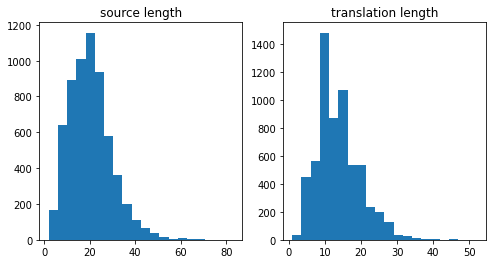

In [36]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);


In [37]:
SRC.vocab.itos[::1000]

['<unk>']

In [38]:
TRG.vocab.itos[::1000]

['<unk>', 'größten']

In [39]:
print(vars(train_data.examples[9]))

{'trg': ['die', 'tiefs', 'sorgen', 'morgen', 'im', 'norden', 'und', 'osten', 'deutschlands', 'für', 'einige', 'wolken', 'in', 'den', 'anderen', 'landesteilen', 'bestimmt', 'hochdruck', 'das', 'wetter'], 'src': ['▁M', 'ORG', 'EN', '▁', 'OST', '▁N', 'ORD', '▁W', 'OL', 'KE', '▁REGI', 'ON', '▁H', 'OCH', '▁DR', 'UC', 'K', '▁M', 'EI', 'STEN', 'S']}


Length distribution in Test data


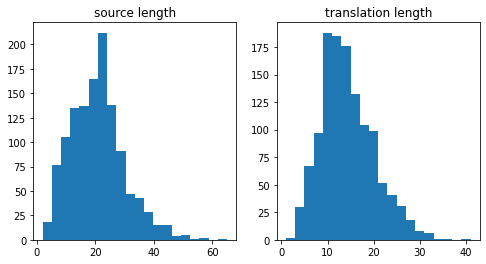

In [40]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [42]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 16
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [43]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 16]
	[.trg]:[torch.LongTensor of size 30x16]
	[.src]:[torch.LongTensor of size 39x16]
torch.Size([39, 16]) torch.Size([30, 16])


In [44]:
encoder_model.config.hidden_size

512

In [45]:
INPUT_DIM = len(SRC.vocab)
print('INPUT_DIM', INPUT_DIM)
OUTPUT_DIM = len(TRG.vocab)
print('OUTPUT_DIM', OUTPUT_DIM)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = encoder_model.config.hidden_size
print('HID_DIM', HID_DIM)
N_LAYERS = 2
DROPOUT = 0.5

INPUT_DIM 489
OUTPUT_DIM 1691
HID_DIM 512


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim*2, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias=False)
        
    def forward(self, s, enc_output):
        
        # s = [batch_size, hid_dim]
        # enc_output = [src_len, batch_size, hid_dim * 2]
        
        batch_size = enc_output.shape[1]
        src_len = enc_output.shape[0]
        
        # repeat decoder hidden state src_len times
        # s = [batch_size, src_len, hid_dim]
        # enc_output = [batch_size, src_len, hid_dim * 2]
        s = s.unsqueeze(1).repeat(1, src_len, 1)
        enc_output = enc_output.transpose(0, 1)
        
        # energy = [batch_size, src_len, hid_dim]
        energy = torch.tanh(self.attn(torch.cat((s, enc_output), dim=2)))
        
        # attention = [batch_size, src_len]
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)



In [47]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=hid_dim * 2,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )

        self.fc_out = nn.Linear((hid_dim * 2) + emb_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        
    def forward(self, dec_input, hidden, cell):
        
        # dec_input = [batch size]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        # enc_output = [src len, batch size, hid dim * 2]
        
        dec_input = dec_input.unsqueeze(1) # [batch_size, 1]
       # print('dec_input11',dec_input.shape)
        # embedded = [batch size, 1, emb dim]
        embedded = self.dropout(self.embedding(dec_input))
       # print('embedded11',embedded.shape)
        #print('hidden11', hidden.shape)
       # print('cell11', cell.shape)
        a = self.attention(hidden[-1], cell) # [batch_size, src_len] 
        #print('a1', a.shape)
        # a = [batch size, 1, src_len]
        a = a.unsqueeze(1)
        #print('a2', a.shape)
        # enc_output = [batch size, src len, hid dim * 2]
        cell = cell.transpose(0, 1)
        #print('cell', cell.shape)
        #cell torch.Size([16, 1, 512])
        # c = [batch size, 1, hid dim * 2]
        c = torch.bmm(a, cell).transpose(0, 1)
        
        #  c torch.Size([1, 16, 512])
        # rnn_input = [1, batch size, (enc_hid_dim * 2) + emb_dim]
        rnn_input = torch.cat((embedded.transpose(0, 1), c), dim=2)
        
        # print('rnn_input', rnn_input.shape)
        # rnn_input torch.Size([1, 16, 1024])
       
        
        # dec_output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        dec_output, hidden = self.rnn(rnn_input, hidden)
        # print('hidden', hidden.shape)
        # hidden torch.Size([1, 16, 512])
        # dec_output = [batch size, hid dim]
        # embedded = [batch size, emb dim]
        # c = [batch size, hid dim * 2]
        dec_output = dec_output.squeeze(0)
        #print('dec_output',dec_output.shape)
        
        # dec_output torch.Size([16, 512])
        embedded = embedded.squeeze(1)
        c = c.squeeze(0)
        #c torch.Size([16, 512])
        #print('embedded', embedded.shape)
        #print('c', c.shape)
        # prediction = [batch size, output dim]
        #print('(hid_dim * 2) + emb_dim', (512 * 2) + 512)
        prediction = self.fc_out(torch.cat((dec_output, c, embedded), dim=1))
        #print('prediction',prediction.shape)
        # prediction torch.Size([16, 1365])
        #print('hidden.squeeze(0)', hidden.squeeze(0).shape)
        return prediction, hidden



In [49]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder_model, decoder, device):
        super().__init__()
        self.encoder = encoder_model
        self.decoder = decoder
        self.device = device
        
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
    
    # src = [src len, batch size]
    # trg = [trg len, batch size]
    
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        
        trg_vocab_size = self.decoder.output_dim
        #print('trg.shape', trg.shape)
        # [35, 16]
        # tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
    
        # get encoder output
        with torch.no_grad():
            enc_output = self.encoder(src)[0]
            #print('enc_output',enc_output.shape)

        # initialize hidden and cell states
        hidden = torch.zeros(self.decoder.n_layers, batch_size, self.decoder.hid_dim).to(self.device)
        #cell = torch.zeros(self.decoder.n_layers, batch_size, self.decoder.hid_dim).to(self.device)
        cell = enc_output
        #print('cellEnc', cell.shape)
        #print('hiddenEnc', hidden.shape)
        # get first input token
        dec_input = trg[0, :]
        #print('trg[0, :]',dec_input.shape)
        # iterate over sequence tokens and predict outputs
        for t in range(1, max_len):
            #print('t iter', t)
            output, hidden = self.decoder(dec_input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            dec_input = (trg[t] if teacher_force else top1)

        #print('outputs', outputs.shape)
        return outputs

In [50]:
enc = encoder_model
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, Attention(HID_DIM))


# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 56,589,979 trainable parameters


In [53]:
PAD_IDX = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
optimizer = optim.Adam(model.parameters())


In [54]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)


In [55]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [56]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [57]:
train_history = []
valid_history = []

N_EPOCHS = 8
CLIP = 1

best_valid_loss = float('inf')

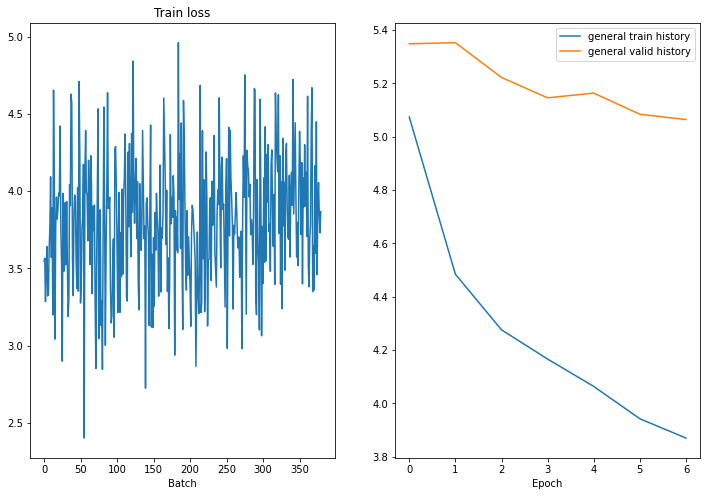

Epoch: 08 | Time: 16m 1s
	Train Loss: 3.800 | Train PPL:  44.682
	 Val. Loss: 5.088 |  Val. PPL: 161.999


In [450]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [451]:
import utils
import imp

In [452]:
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [453]:
batch = next(iter(test_iterator))

In [454]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: vorsicht glätte
Generated: vorsicht glätte sorgen es glatt werden

Original: auch im westen wird es wieder freundlich
Generated: aber auch wird es wird es dann auch wärmer und westen



In [455]:
import tqdm

In [456]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

78it [00:33,  2.32it/s]


In [457]:
from nltk.translate.bleu_score import corpus_bleu
corpus_bleu([[text] for text in original_text], generated_text) * 100

9.561769871415986